In [126]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing.image import ImageDataGenerator

TRAINING_DIR = "../dataset"
training_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.15)


train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(120, 120),
    class_mode='categorical',
    batch_size=16,
    subset='training'
)

validation_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(120, 120),
    class_mode='categorical',
    batch_size=16,
    subset='validation'
)

Found 384 images belonging to 4 classes.
Found 67 images belonging to 4 classes.


In [142]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(120, 120, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])
# model = tf.keras.Sequential([
#     tf.keras.layers.Flatten(input_shape=(204, 136, 3)),
#     tf.keras.layers.Dense(units=1),
#     tf.keras.layers.Dense(4, activation='softmax')
# ])

In [144]:
model.summary()

model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 118, 118, 64)      1792      
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 59, 59, 64)        0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 59, 59, 64)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 57, 57, 64)        36928     
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 26, 26, 128)     

In [145]:
%%time

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10)
]

history = model.fit_generator(
    train_generator,
    epochs=60,
    steps_per_epoch=train_generator.samples // 16,
    validation_data=validation_generator, 
    validation_steps=validation_generator.samples // 16,
    callbacks=callbacks,
)


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 24 steps, validate for 4 steps
Epoch 1/60
24/24 [==============================] - 14s 581ms/step - loss: 1.3316 - accuracy: 0.4375 - val_loss: 1.3507 - val_accuracy: 0.4688
Epoch 2/60
24/24 [==============================] - 13s 530ms/step - loss: 1.2966 - accuracy: 0.4427 - val_loss: 1.3051 - val_accuracy: 0.4688
Epoch 3/60
24/24 [==============================] - 13s 529ms/step - loss: 1.2788 - accuracy: 0.4609 - val_loss: 1.2949 - val_accuracy: 0.4688
Epoch 4/60
24/24 [==============================] - 13s 531ms/step - loss: 1.1552 - accuracy: 0.5234 - val_loss: 1.3225 - val_accuracy: 0.4688
Epoch 5/60
24/24 [==============================] - 13s 529ms/step - loss: 1.1626 - accuracy: 0.5469 - val_loss: 1.2688 - val_accuracy: 0.4688
Epoch 6/60
24/24 [==============================] - 13s 547ms/step - loss: 1.1033 - accuracy: 0.5469 - val_loss: 1.2997 - val_accuracy: 0.4688
Epoch 7/60
24/24 [==============================] -

In [152]:
model.save("cycle_classifier_proto.h5")

Text(0.5, 1.0, 'Training and validation loss')

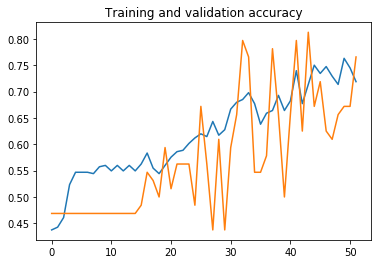

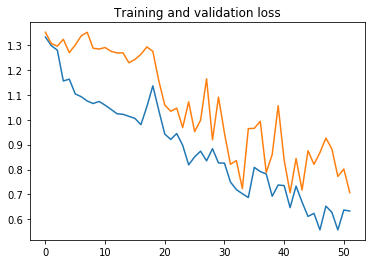

In [147]:
%matplotlib inline

import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [148]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

Y_pred = model.predict_generator(validation_generator, validation_generator.samples // 16+1)
y_pred = np.argmax(Y_pred, axis=1)

In [149]:
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))

Confusion Matrix
[[ 7  0  6  2]
 [ 2  1  4  0]
 [ 5  1 21  3]
 [ 3  1  6  5]]


In [151]:
print('Classification Report')
target_names = ['Autre', 'Organique', 'Recyclable', 'Verre']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

       Autre       0.41      0.47      0.44        15
   Organique       0.33      0.14      0.20         7
  Recyclable       0.57      0.70      0.63        30
       Verre       0.50      0.33      0.40        15

    accuracy                           0.51        67
   macro avg       0.45      0.41      0.42        67
weighted avg       0.49      0.51      0.49        67



Pistes d'améliorations rapides:
- contrer le déséquilibre des classes (https://medium.com/analytics-vidhya/how-to-apply-data-augmentation-to-deal-with-unbalanced-datasets-in-20-lines-of-code-ada8521320c9)
- utiliser du transfer learning pour commencer avec un modèle plus robuste et déjà entrainé (DenseNet, ResNet, VGG16, EfficientNet)
- équilibrer le dataset en rajoutant/retirant des images

In [123]:
model_DN121 = tf.keras.Sequential([tf.keras.applications.MobileNetV2(weights='imagenet',
                                                                     input_shape=(120, 120, 3),
                                                                     include_top=False,
                                                                     pooling='max'
                                                                    ),
                                 tf.keras.layers.Dense(4, activation='softmax')])

In [124]:
model_DN121.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [125]:
def build_lrfn(lr_start=0.00001, lr_max=0.00005, 
               lr_min=0.00001, lr_rampup_epochs=3, 
               lr_sustain_epochs=0, lr_exp_decay=.8):
    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) *\
                 lr_exp_decay**(epoch - lr_rampup_epochs\
                                - lr_sustain_epochs) + lr_min
        return lr
    return lrfn

lr_schedule = tf.keras.callbacks.LearningRateScheduler(build_lrfn(), verbose=1)

In [127]:
%%time
history = model_DN121.fit_generator(
    train_generator,
    epochs=15,
    steps_per_epoch=train_generator.samples // 16,
    validation_data=validation_generator, 
    validation_steps=validation_generator.samples // 16,
    callbacks=[lr_schedule],
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 24 steps, validate for 4 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/15
24/24 [==============================] - 63s 3s/step - loss: 4.2799 - accuracy: 0.2135 - val_loss: 4.8999 - val_accuracy: 0.1562

Epoch 00002: LearningRateScheduler reducing learning rate to 2.3333333333333336e-05.
Epoch 2/15
24/24 [==============================] - 13s 538ms/step - loss: 2.7172 - accuracy: 0.3594 - val_loss: 4.8779 - val_accuracy: 0.1094

Epoch 00003: LearningRateScheduler reducing learning rate to 3.666666666666667e-05.
Epoch 3/15
24/24 [==============================] - 13s 542ms/step - loss: 1.6043 - accuracy: 0.5365 - val_loss: 5.5854 - val_accuracy: 0.1562

Epoch 00004: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 4/15
24/24 [==============================] - 32s 1s/step - loss: 1.1172 - accuracy: 0.6745 - val_loss: 5.7092 - val_accuracy: 0.0938

Epoch 00005: LearningRateSchedule

In [20]:
model_DN121.save("cycle_classifier_DN121.h5")

Text(0.5, 1.0, 'Training and validation loss')

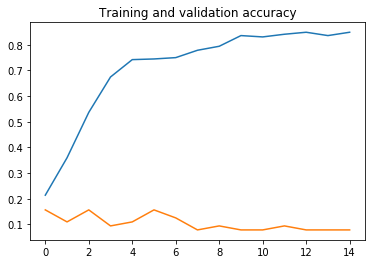

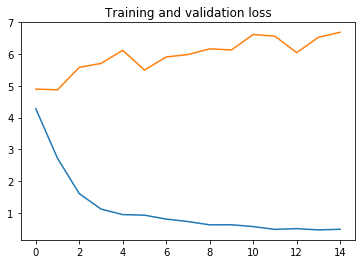

In [128]:
%matplotlib inline

import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [23]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

Y_pred = model_DN121.predict_generator(validation_generator, validation_generator.samples // 16+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))

print('Classification Report')
target_names = ['Autre', 'Organique', 'Recyclable', 'Verre']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[2 2 4 2]
 [0 1 2 2]
 [6 1 6 7]
 [4 1 4 1]]
Classification Report
              precision    recall  f1-score   support

       Autre       0.17      0.20      0.18        10
   Organique       0.20      0.20      0.20         5
  Recyclable       0.38      0.30      0.33        20
       Verre       0.08      0.10      0.09        10

    accuracy                           0.22        45
   macro avg       0.21      0.20      0.20        45
weighted avg       0.24      0.22      0.23        45



In [2]:
model = tf.keras.models.load_model("cycle_classifier_proto.h5")

In [3]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

7608064

In [6]:
from PIL import Image
import tensorflow as tf
import numpy as np

In [4]:
interpreter = tf.lite.Interpreter(model_path="converted_model.tflite")
interpreter.allocate_tensors()

In [26]:
im = Image.open('../dataset/verre/biere_2.jpg')
im_resized = im.resize((120, 120))
data = list(im_resized.getdata())
arr = np.asarray(data, dtype="float32") 
arr = np.reshape(arr, (1, 120, 120 , 3))

In [27]:
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_data = arr
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

In [28]:
tflite_results

array([[0., 0., 0., 1.]], dtype=float32)